# First GOP Debate Twitter Sentiment  
Comparing the use of AutoML and Deep Learning Architectures (Bi-Directional LSTM) to predict Twitter Sentiments  

**Sentiment Analysis**: the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

In [54]:
from __future__ import division

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.style.use('fivethirtyeight')

In [97]:
from sklearn.metrics import confusion_matrix as cf
from sklearn.metrics import accuracy_score

In [132]:
from tpot import TPOTClassifier
from deap import creator
from sklearn.model_selection import cross_val_score

### Load Data

In [166]:
data = pd.read_csv('data/first-gop-debate-twitter-sentiment/Sentiment.csv')

In [167]:
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


### Data Discovery

Number of Candidate Tweet Mentions

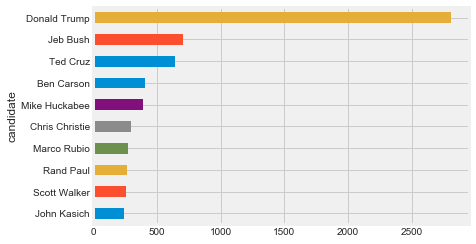

In [176]:
data.groupby(['candidate']).size().drop('No candidate mentioned').sort_values().plot(kind = 'barh')

Number of candidate mentions cross-referenced to the sentiments of the tweets.

In [185]:
pd.crosstab(data.candidate, data.sentiment).drop('No candidate mentioned').sort_values('Negative', ascending = False)

sentiment,Negative,Neutral,Positive
candidate,,,
Donald Trump,1758,446,609
Jeb Bush,589,72,44
Mike Huckabee,237,83,73
Ted Cruz,221,126,290
Chris Christie,218,42,33
Ben Carson,186,54,164
Scott Walker,179,38,42
Rand Paul,148,60,55
Marco Rubio,105,51,119


Tweets per user timezone

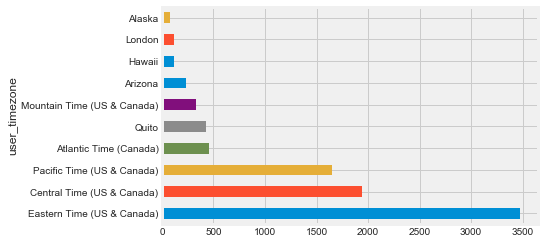

In [208]:
data.groupby('user_timezone').size().sort_values(ascending = False)[:10].plot(kind='barh')

Subject Matter Mentions of each Candidate

In [213]:
pd.crosstab(data.subject_matter, data.candidate)\
.drop('No candidate mentioned', axis = 1)\
.drop('None of the above').sort_values('Donald Trump', ascending = False)

candidate,Ben Carson,Chris Christie,Donald Trump,Jeb Bush,John Kasich,Marco Rubio,Mike Huckabee,Rand Paul,Scott Walker,Ted Cruz
subject_matter,,,,,,,,,,
FOX News or Moderators,16,11,849,156,4,4,4,5,11,62
Women's Issues (not abortion though),1,1,114,7,0,3,10,1,4,0
Immigration,0,6,62,23,0,19,1,0,3,6
Jobs and Economy,6,7,40,19,10,17,14,6,10,2
Foreign Policy,9,35,26,21,1,3,45,13,25,31
Abortion,1,2,17,12,2,26,18,1,29,4
Religion,10,1,14,1,4,12,3,1,12,19
Racial issues,70,1,12,3,1,2,6,1,9,0
Healthcare (including Medicare),4,2,6,3,7,1,6,1,2,4


In [228]:
# create numerical categories for the sentiments
data['sentiment_num'] = np.argmax(pd.get_dummies(data['sentiment']).as_matrix(), axis = 1)

# retain only the numeric columns of the data
data_num = data[data.columns[data.dtypes != 'object']].drop(['tweet_id','id'], axis = 1) 

Heatmap of the correlation coefficients of each variables with each other

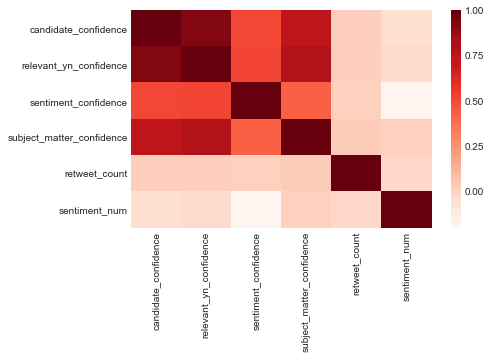

In [229]:
sns.heatmap(data_num.corr(), cmap = 'Reds')

Pairplot showing distributions of variables with each other

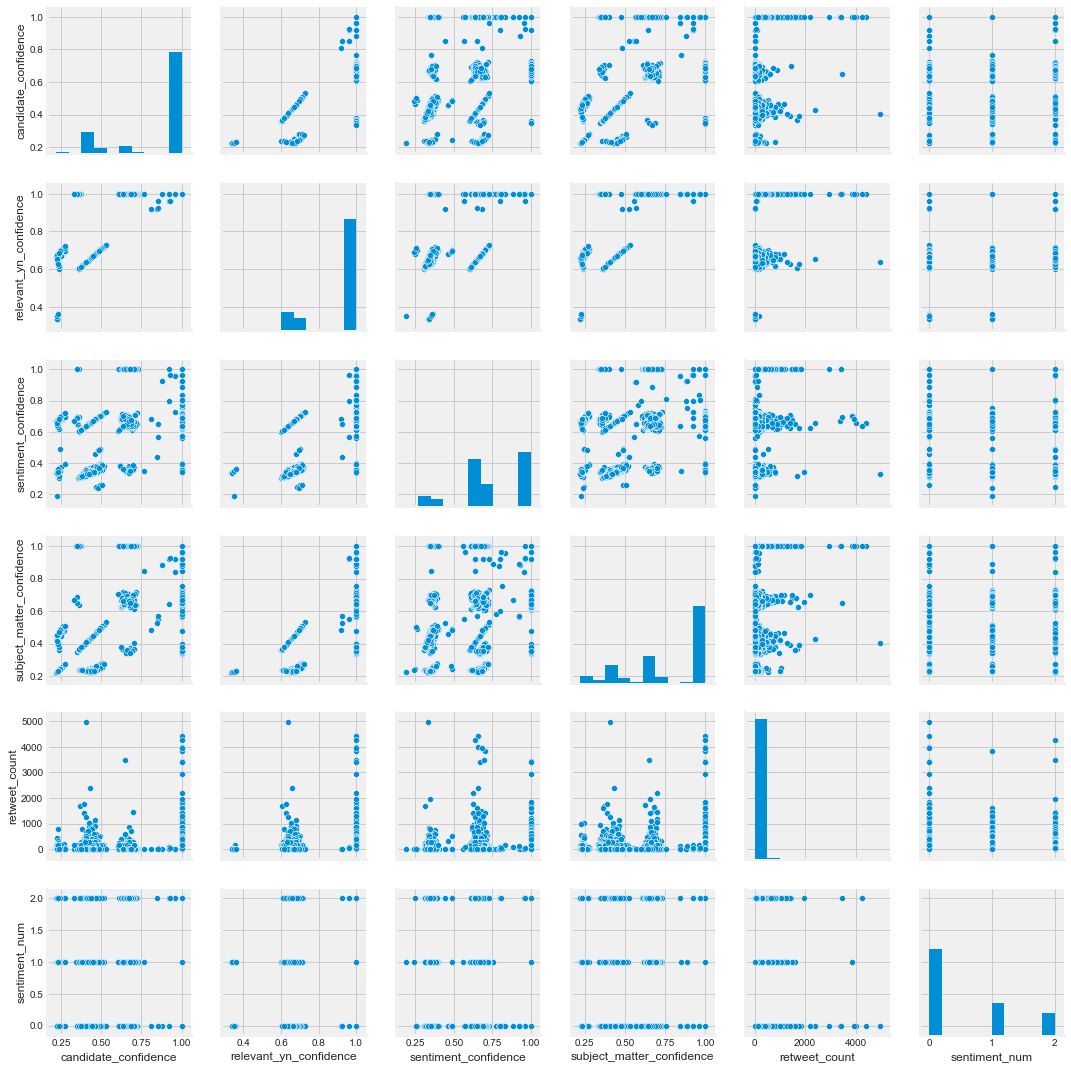

In [230]:
sns.pairplot(data_num)

### Clean Data

In [ ]:
# Keep the sentiments only
data = data[['text','sentiment']]

In [24]:
# Lowercase, clean non-alphanumeric characters and remove 'rt's
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x.lower()))\
.str\
.replace('rt', '') 

### Tokenize

In [81]:
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
y = pd.get_dummies(data['sentiment'])

In [82]:
X.shape

(13871, 28)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9293, 28) (9293, 3)
(4578, 28) (4578, 3)


# Auto-Machine Learning using TPOT

In [159]:
tpot = TPOTClassifier(generations=5, max_time_mins=15, max_eval_time_mins=0.04, population_size=50, verbosity = 2)
tpot.fit(X_train, np.argmax(y_train.as_matrix(), axis = 1))
print(tpot.score(X_test, np.argmax(y_test.as_matrix(), axis = 1)))

Optimization Progress: 156pipeline [02:08,  1.20s/pipeline]

Generation 1 - Current best internal CV score: 0.6287494266754423


Optimization Progress: 235pipeline [03:20,  1.52pipeline/s]

Generation 2 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 295pipeline [04:07,  1.16s/pipeline]

Generation 3 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 353pipeline [04:38,  1.49pipeline/s]

Generation 4 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 413pipeline [05:15,  1.44pipeline/s]

Generation 5 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 472pipeline [09:22,  1.06s/pipeline]

Generation 6 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 530pipeline [09:55,  2.42pipeline/s]

Generation 7 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 587pipeline [10:21,  3.66pipeline/s]

Generation 8 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 646pipeline [10:52,  1.16s/pipeline]

Generation 9 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 705pipeline [11:29,  1.27pipeline/s]

Generation 10 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 766pipeline [12:05,  3.90pipeline/s]

Generation 11 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 833pipeline [12:53,  1.07s/pipeline]

Generation 12 - Current best internal CV score: 0.6354254733423084


Optimization Progress: 886pipeline [13:22,  1.11pipeline/s]

Generation 13 - Current best internal CV score: 0.6370390710366727


Optimization Progress: 945pipeline [14:01,  2.44pipeline/s]

Generation 14 - Current best internal CV score: 0.6408055796004853


Optimization Progress: 1008pipeline [14:46,  1.10pipeline/s]

Generation 15 - Current best internal CV score: 0.6408055796004853



15.0014934 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.25, min_samples_leaf=7, min_samples_split=8, n_estimators=100)
0.6391437308868502


### Check Which Models were Evaluated

In [163]:
pd.DataFrame(dict(list(tpot.evaluated_individuals_.items()))).T\
.replace([np.inf, -np.inf], np.nan)\
.dropna()\
.drop('generation', axis = 1)\
.sort_values('internal_cv_score', ascending = False)\
.head()

,crossover_count,internal_cv_score,mutation_count,operator_count,predecessor
"ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=gini, ExtraTreesClassifier__max_features=0.25, ExtraTreesClassifier__min_samples_leaf=7, ExtraTreesClassifier__min_samples_split=8, ExtraTreesClassifier__n_estimators=100)",0,0.640806,3,1,"(ExtraTreesClassifier(input_matrix, ExtraTrees..."
"ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.25, ExtraTreesClassifier__min_samples_leaf=9, ExtraTreesClassifier__min_samples_split=8, ExtraTreesClassifier__n_estimators=100)",0,0.637039,2,1,"(ExtraTreesClassifier(input_matrix, ExtraTrees..."
"ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.25, ExtraTreesClassifier__min_samples_leaf=11, ExtraTreesClassifier__min_samples_split=12, ExtraTreesClassifier__n_estimators=100)",0,0.635425,3,1,"(ExtraTreesClassifier(input_matrix, ExtraTrees..."
"ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.25, ExtraTreesClassifier__min_samples_leaf=11, ExtraTreesClassifier__min_samples_split=14, ExtraTreesClassifier__n_estimators=100)",0,0.635425,2,1,"(ExtraTreesClassifier(input_matrix, ExtraTrees..."
"ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.25, ExtraTreesClassifier__min_samples_leaf=11, ExtraTreesClassifier__min_samples_split=8, ExtraTreesClassifier__n_estimators=100)",0,0.635425,1,1,"(ExtraTreesClassifier(input_matrix, ExtraTrees..."


### Prediction Score Using TPOT

In [161]:
y_pred_tpot = tpot.predict(X_test)

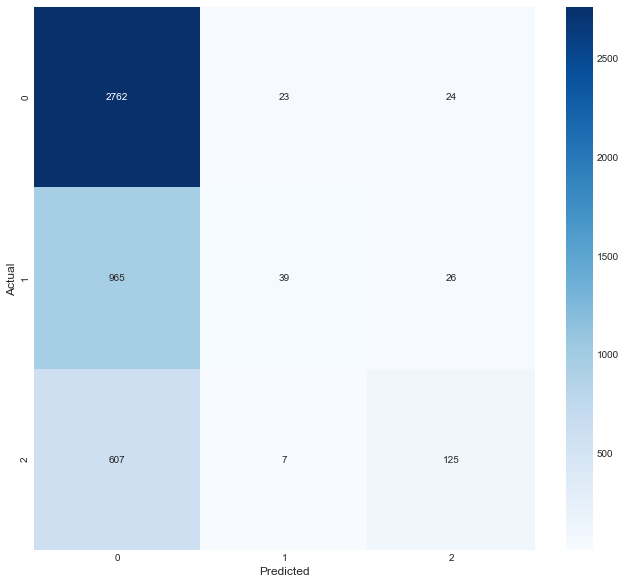

In [162]:
conf_mat = cf(np.argmax(y_test.as_matrix(), axis = 1), y_pred_tpot)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Using Deep Learning (Recurrent Neural Networks)

In [153]:
# Deep Learning Architecture Parameters
input_dim = 2000
output_dim = 128
dropout = 0.8
rec_dpout = 0.8
LSTM_units = 256

# Model fit Parameters
batch_size = 200
epochs = 30
val_split = 0.3
dense_out = 3 # three categories

In [154]:
model = Sequential()

model.add( Embedding(input_dim=input_dim, output_dim = output_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(dropout))
model.add(LSTM(LSTM_units, dropout = dropout, recurrent_dropout=rec_dpout,return_sequences=True))
model.add(LSTM(LSTM_units, dropout = dropout, recurrent_dropout=rec_dpout, return_sequences=False))
model.add( Dense(dense_out, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [155]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 28, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 28, 256)           394240    
_________________________________________________________________
lstm_18 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 1,176,323
Trainable params: 1,176,323
Non-trainable params: 0
_________________________________________________________________
None


### Train 2-LSTM Model

Train on 6505 samples, validate on 2788 samples
Epoch 1/30
6505/6505 [==============================] - 25s 4ms/step - loss: 1.0095 - acc: 0.5422 - val_loss: 0.9302 - val_acc: 0.6115
Epoch 2/30
6505/6505 [==============================] - 22s 3ms/step - loss: 0.9506 - acc: 0.6086 - val_loss: 0.9274 - val_acc: 0.6115
Epoch 3/30
6505/6505 [==============================] - 20s 3ms/step - loss: 0.9422 - acc: 0.6103 - val_loss: 0.9258 - val_acc: 0.6115
Epoch 4/30
6505/6505 [==============================] - 20s 3ms/step - loss: 0.9413 - acc: 0.6112 - val_loss: 0.9205 - val_acc: 0.6115
Epoch 5/30
6505/6505 [==============================] - 24s 4ms/step - loss: 0.9330 - acc: 0.6117 - val_loss: 0.9146 - val_acc: 0.6115
Epoch 6/30
6505/6505 [==============================] - 22s 3ms/step - loss: 0.9215 - acc: 0.6118 - val_loss: 0.8997 - val_acc: 0.6115
Epoch 7/30
6505/6505 [==============================] - 21s 3ms/step - loss: 0.9121 - acc: 0.6111 - val_loss: 0.8794 - val_acc: 0.6115
Epoch 8

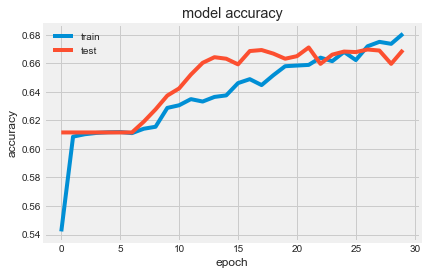

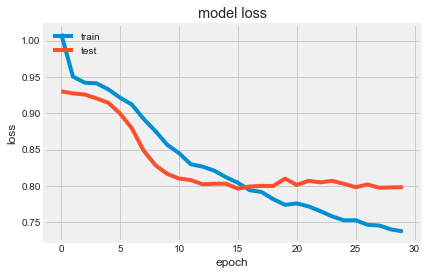

In [156]:

history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=val_split)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [157]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.79
acc: 0.66


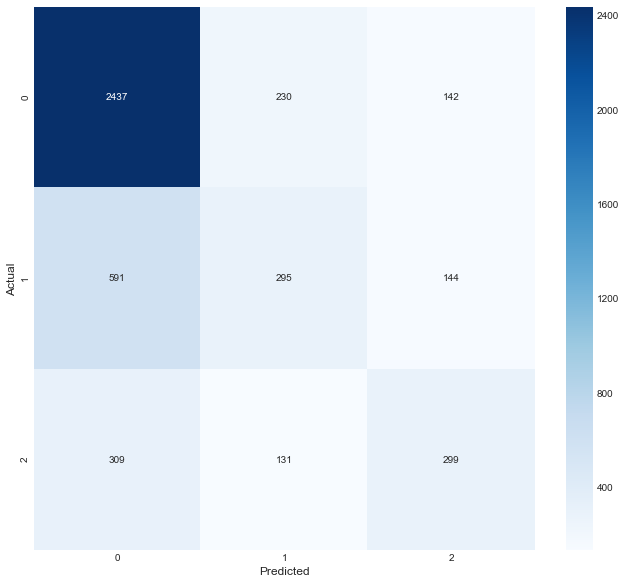

In [158]:
y_pred = model.predict(X_test)

conf_mat = cf(np.argmax(y_test.as_matrix(), axis = 1), np.argmax(y_pred, axis = 1))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Conclusion  
2-LSTM worked better than AutoML which swept through 1008 different kinds of predictive models tried out by TPOT: an AutoML python package.